Useful links:
- https://docs.nvidia.com/nsight-compute/NsightComputeCli/index.html#nvprof-metric-comparison
- https://docs.nvidia.com/cuda/profiler-users-guide/index.html#metrics-reference-7x
- https://canvas.kth.se/courses/36161/assignments/223741
- https://canvas.kth.se/courses/36161/pages/tutorial-timing-your-kernel-cpu-timer-and-nvprof?module_item_id=561394

In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Sat Jan  7 14:44:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |      

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/DD2360 Applied GPU Programming KTH/hw_4/ex_3'
!ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DD2360 Applied GPU Programming KTH/hw_4/ex_3
hw4_ex3_pinned_memory_and_unified_memory.ipynb	lab4_ex3_um.cu
lab4_ex3_pinned.cu


## Pinned memory

In [10]:
!nvcc -arch=sm_75 ./lab4_ex3_pinned.cu -o lab4_ex3_pinned
#!./lab4_ex3_pinned 512 1024 1024 4096
!nvprof ./lab4_ex3_pinned 512 1024 1024 4096

Input matrix dim (512 x 1024) (1024 x 4096) (512 x 4096)
==5105== NVPROF is profiling process 5105, command: ./lab4_ex3_pinned 512 1024 1024 4096
CPU and GPU results are equal.
==5105== Profiling application: ./lab4_ex3_pinned 512 1024 1024 4096
==5105== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   89.58%  18.744ms         1  18.744ms  18.744ms  18.744ms  gemm(float*, float*, float*, int, int, int, int)
                    7.37%  1.5420ms         2  770.99us  175.77us  1.3662ms  [CUDA memcpy HtoD]
                    3.05%  637.26us         1  637.26us  637.26us  637.26us  [CUDA memcpy DtoH]
      API calls:   93.16%  315.98ms         3  105.33ms  3.2541ms  305.89ms  cudaHostAlloc
                    6.19%  21.003ms         3  7.0009ms  228.67us  19.394ms  cudaMemcpy
                    0.31%  1.0656ms         7  152.23us     630ns  754.67us  cudaFree
                    0.15%  492.99us         3  164.33us  91.09

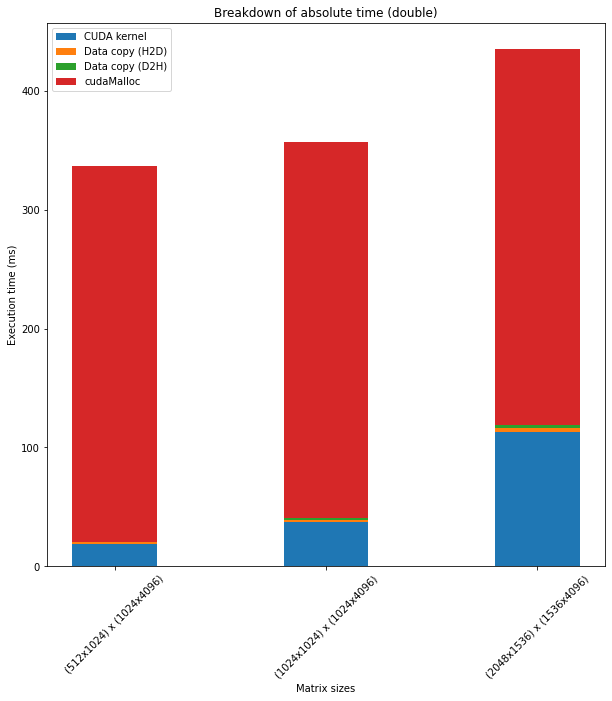

In [11]:
# DATATYPE FLOAT
# PINNED MEMORY
import matplotlib.pyplot as plt
import numpy as np

matrix_sizes = ['(512x1024) x (1024x4096)', '(1024x1024) x (1024x4096)', '(2048x1536) x (1536x4096)']
cuda_kernel_abs = np.array([18.744, 37.417, 113.00])
datacpy_d2h_abs = np.array([0.6373, 1.2741, 2.5499])
datacpy_h2d_abs = np.array([1.5420, 1.7062, 3.0688])
cudaMalloc_abs = np.array([315.98, 316.88, 316.81])

width = 0.4
fig, ax = plt.subplots(1, 1)

ax.bar(matrix_sizes, cuda_kernel_abs, width, label='CUDA kernel')
ax.bar(matrix_sizes, datacpy_h2d_abs, width, bottom=cuda_kernel_abs,
       label='Data copy (H2D)')
ax.bar(matrix_sizes, datacpy_d2h_abs, width, bottom=datacpy_h2d_abs+cuda_kernel_abs,
       label='Data copy (D2H)')
ax.bar(matrix_sizes, cudaMalloc_abs, width, bottom=datacpy_d2h_abs+datacpy_h2d_abs+cuda_kernel_abs,
       label='cudaMalloc')

ax.set_xlabel('Matrix sizes')
ax.set_ylabel('Execution time (ms)')
ax.set_title('Breakdown of absolute time (double)')
ax.legend()

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
fig.set_size_inches(20/2, 10, forward=True)
plt.show()

## Unified memory

In [18]:
!nvcc -arch=sm_75 ./lab4_ex3_unified.cu -o lab4_ex3_unified
#!./lab4_ex3_unified 512 1024 1024 4096
!nvprof ./lab4_ex3_unified 512 1024 1024 4096

Input matrix dim (512 x 1024) (1024 x 4096) (512 x 4096)
==14170== NVPROF is profiling process 14170, command: ./lab4_ex3_unified 512 1024 1024 4096
CPU and GPU results are equal.
==14170== Profiling application: ./lab4_ex3_unified 512 1024 1024 4096
==14170== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  25.361ms         1  25.361ms  25.361ms  25.361ms  gemm(float*, float*, float*, int, int, int, int)
      API calls:   91.57%  306.01ms         4  76.504ms  12.272us  305.95ms  cudaMallocManaged
                    7.59%  25.369ms         1  25.369ms  25.369ms  25.369ms  cudaDeviceSynchronize
                    0.66%  2.2122ms         4  553.06us  277.50us  936.04us  cudaFree
                    0.10%  348.71us         1  348.71us  348.71us  348.71us  cuDeviceTotalMem
                    0.04%  149.50us       101  1.4800us     127ns  63.668us  cuDeviceGetAttribute
                    0.02%  63.313us      

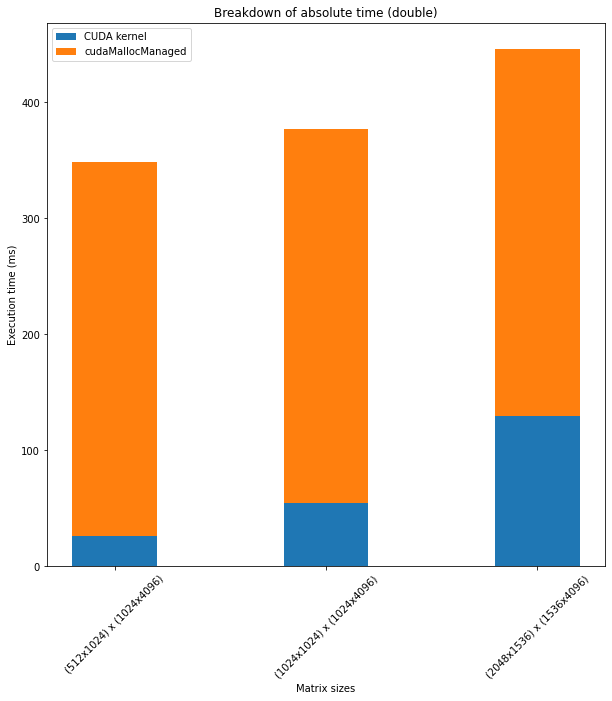

In [17]:
# DATATYPE FLOAT
# UNIFIED MEMORY
import matplotlib.pyplot as plt
import numpy as np

matrix_sizes = ['(512x1024) x (1024x4096)', '(1024x1024) x (1024x4096)', '(2048x1536) x (1536x4096)']
cuda_kernel_abs = np.array([26.032, 54.271, 129.65])
cudaMallocManaged_abs = np.array([322.76, 322.24, 316.38])

width = 0.4
fig, ax = plt.subplots(1, 1)

ax.bar(matrix_sizes, cuda_kernel_abs, width, label='CUDA kernel')
ax.bar(matrix_sizes, cudaMallocManaged_abs, width, bottom=cuda_kernel_abs,
       label='cudaMallocManaged')

ax.set_xlabel('Matrix sizes')
ax.set_ylabel('Execution time (ms)')
ax.set_title('Breakdown of absolute time (double)')
ax.legend()

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
fig.set_size_inches(20/2, 10, forward=True)
plt.show()